In [1]:
import gym
import numpy as np
import torch
from torch import nn
from stable_baselines3 import SAC
from collections import deque
import matplotlib.pyplot as plt

env = gym.make('MountainCarContinuous-v0')

mlp_models = [SAC.load(f'model_{i+1}', env=env) for i in range(6)]

Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


In [2]:
# Define the RNN
class RNN(nn.Module):
    def __init__(self):
        super(RNN, self).__init__()
        self.rnn = nn.LSTM(input_size=2, hidden_size=64, batch_first=True) # LSTM 
        self.fc = nn.Linear(64, 1)  # 64 neurons in the hidden layer

    def forward(self, x):
        x, _ = self.rnn(x)
        x = self.fc(x[:, -1, :])  # Use only the last output
        return x

In [3]:
# Train the RNNs
rnns = []
sequence_length = 5
criterion = nn.MSELoss() # Use MSE
all_losses = []  # Store all losses here


for i, agent in enumerate(mlp_models):
    # Collect state-action pairs
    observations = []
    actions = []
    obs = env.reset()
    for _ in range(10000):  # Collect 10000 steps
        action, _ = agent.predict(obs)
        observations.append(obs)
        actions.append(action)
        obs, reward, done, info = env.step(action)
        if done:
            obs = env.reset()


    # Convert the data into tensors
    observations_tensor = torch.tensor(observations, dtype=torch.float32)
    actions_tensor = torch.tensor(actions, dtype=torch.float32)
    

    # Reshape to sequences
    sequence_length = 5   # Sequence length set to 5
    num_sequences = len(observations) - sequence_length + 1
    observations_seq = torch.zeros((num_sequences, sequence_length, observations_tensor.shape[1]))
    actions_seq = torch.zeros((num_sequences, sequence_length, actions_tensor.shape[1]))
    for j in range(num_sequences):
        observations_seq[j] = observations_tensor[j:j+sequence_length]
        actions_seq[j] = actions_tensor[j:j+sequence_length]


    # Initialise and train the RNN
    rnn = RNN()
    optimiser = torch.optim.Adam(rnn.parameters()) # Use Adam optimiser

    losses = []  # Store losses for this RNN here
    for epoch in range(25):  # Use 25 epochs
        optimiser.zero_grad()
        outputs = rnn(observations_seq)
        loss = criterion(outputs, actions_seq[:, -1, :])
        loss.backward()
        optimiser.step()
        losses.append(loss.item())  # Append the loss for this epoch
        print(f"Epoch {epoch+1}, Loss: {loss.item()}")


    all_losses.append(losses)  # Append the losses for this RNN to all_losses

    rnns.append(rnn)
    
    torch.save(rnn.state_dict(), f'rnn_{i}.pth')
    print(f"Training complete for RNN {i+1}.")

C:\Users\keyma\AppData\Local\Temp\ipykernel_9820\2286438055.py:21: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\cb\pytorch_1000000000000\work\torch\csrc\utils\tensor_new.cpp:233.)
  observations_tensor = torch.tensor(observations, dtype=torch.float32)


Epoch 1, Loss: 0.009171504527330399
Epoch 2, Loss: 0.008306402713060379
Epoch 3, Loss: 0.007916108705103397
Epoch 4, Loss: 0.007930454798042774
Epoch 5, Loss: 0.008131973445415497
Epoch 6, Loss: 0.00826069712638855
Epoch 7, Loss: 0.00823759101331234
Epoch 8, Loss: 0.008121130988001823
Epoch 9, Loss: 0.007991805672645569
Epoch 10, Loss: 0.007905261591076851
Epoch 11, Loss: 0.007881962694227695
Epoch 12, Loss: 0.00791087280958891
Epoch 13, Loss: 0.007962046191096306
Epoch 14, Loss: 0.008003966882824898
Epoch 15, Loss: 0.008017505519092083
Epoch 16, Loss: 0.008000403642654419
Epoch 17, Loss: 0.007963336072862148
Epoch 18, Loss: 0.007922504097223282
Epoch 19, Loss: 0.007892543449997902
Epoch 20, Loss: 0.007881542667746544
Epoch 21, Loss: 0.0078889736905694
Epoch 22, Loss: 0.007906981743872166
Epoch 23, Loss: 0.007924608886241913
Epoch 24, Loss: 0.00793302059173584
Epoch 25, Loss: 0.007929070852696896
Training complete for RNN 1.
Epoch 1, Loss: 0.028444217517971992
Epoch 2, Loss: 0.02441762

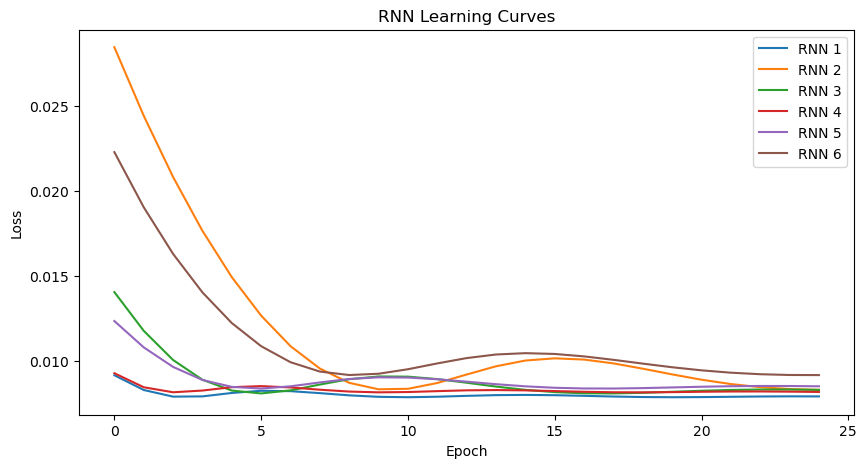

In [4]:
# Plot the learning curves for all RNNs

plt.figure(figsize=(10, 5))

for i, losses in enumerate(all_losses):
    plt.plot(losses, label=f'RNN {i+1}')

plt.title("RNN Learning Curves")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.savefig('rnn_1.png', dpi=300, bbox_inches='tight')
plt.show()

In [5]:
def evaluate(model, env, num_episodes=100): # Use 100 episodes
    rewards = []
    for _ in range(num_episodes):
        obs = env.reset()
        done = False
        episode_reward = 0
        obs_deque = deque([obs for _ in range(sequence_length)], maxlen=sequence_length)
        while not done:
            obs_seq = torch.tensor(list(obs_deque), dtype=torch.float32).unsqueeze(0)
            action = model(obs_seq)[0].detach().numpy()
            action = np.clip(action, -1.0, 1.0)  # Ensure the action is within the valid range
            obs, reward, done, _ = env.step(action)
            episode_reward += reward
            obs_deque.append(obs)
        rewards.append(episode_reward)
    return np.mean(rewards), np.std(rewards)  # Return mean and std of rewards


In [6]:
# List to hold the mean rewards and standard deviations for each network
mean_rewards = []
std_rewards = []

# Evaluate each RNN and save the results
for i, rnn in enumerate(rnns):
    mean_reward, std_reward = evaluate(rnn, env)
    mean_rewards.append(mean_reward)
    std_rewards.append(std_reward)
    print(f"RNN {i+1}: Average reward = {mean_reward:.5f}, Standard deviation = {std_reward:.5f}")

RNN 1: Average reward = -0.06045, Standard deviation = 0.00019
RNN 2: Average reward = -0.09045, Standard deviation = 0.00025
RNN 3: Average reward = -0.00127, Standard deviation = 0.00005
RNN 4: Average reward = -0.00106, Standard deviation = 0.00015
RNN 5: Average reward = -0.00579, Standard deviation = 0.00001
RNN 6: Average reward = -0.00151, Standard deviation = 0.00052


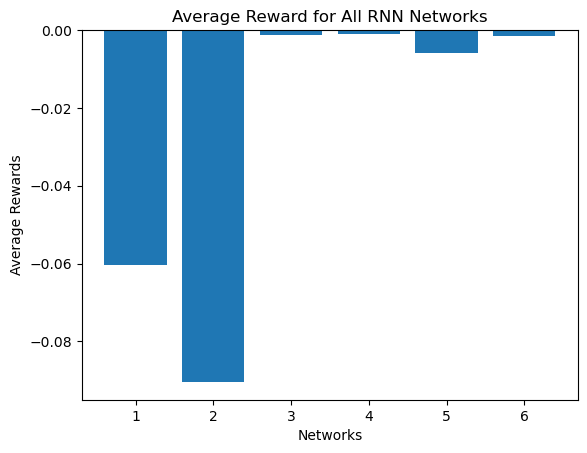

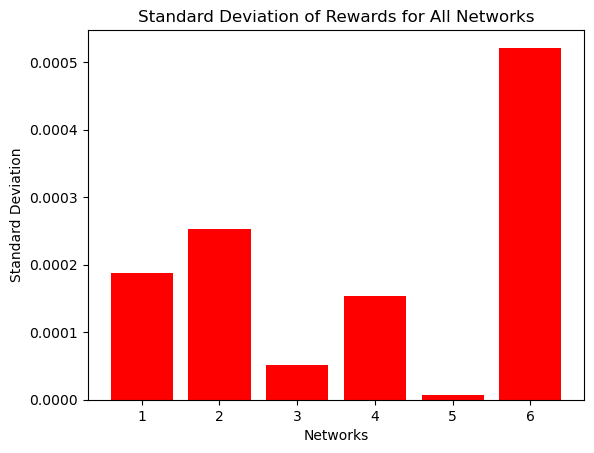

In [7]:
network_labels = [f"{i + 1}" for i in range(len(mlp_models))]

# Plot for the average rewards
plt.figure()
plt.bar(network_labels, mean_rewards)
plt.xlabel("Networks")
plt.ylabel('Average Rewards')
plt.title('Average Rewards for All RNN Networks')
plt.savefig('rnn_2.png', dpi=300, bbox_inches='tight')
plt.show()

# Plot for the standard deviation
plt.figure()
plt.bar(network_labels, std_rewards, color = 'red')
plt.xlabel("Networks")
plt.ylabel('Standard Deviation')
plt.title('Standard Deviation of Rewards for All Networks')
plt.savefig('rnn_3.png', dpi=300, bbox_inches='tight')
plt.show()